In [1]:
import cudf as pd
from tqdm.auto import tqdm

from time import time

In [15]:
def import_labelled_data(path="data/level-0.5/data.json"):
    data = pd.read_json(path, encoding="latin-1")
    return data



print("Loading data...")

test_dataset = import_labelled_data(path="../../data/level-0.5/irrelevant.json", )

print("Data loaded.")


# test_dataset = test_dataset.sample(2500)

test_dataset = test_dataset.sample(frac=1).reset_index(drop=True)


test_dataset.info()
test_dataset.head()

Loading data...


/workspace/GreyLit/venv/lib/python3.10/site-packages/cudf/io/json.py:108: UserWarning: Using CPU via Pandas to read JSON dataset, this may be GPU accelerated in the future
  warnings.warn(


Data loaded.
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 10688 entries, 0 to 10687
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   url           10688 non-null  object
 1   text          10688 non-null  object
 2   relevance     10688 non-null  object
 3   multiclasses  10688 non-null  list
dtypes: list(1), object(3)
memory usage: 1.3+ GB


,url,text,relevance,multiclasses
0,https://www.kanungu.go.ug/sites/default/files/..., KANUNGU DISTRICT HIV AND AIDS STRATEGIC PLAN...,irrelevant,[]
1,https://documents1.worldbank.org/curated/en/64...,d e z i r o h t u A WB Report No.107108 e r u ...,irrelevant,[]
2,https://repositorio.unac.edu.pe/bitstream/hand...,UNIVERSIDAD NACIONAL DEL CALLAO ESCUELA DE POS...,irrelevant,[]
3,https://www.workforcebusinessdevelopment.org/_...,LIGHTHOUSE LIGHTHOUSE WHY ARE GOALS SO DIFFICU...,irrelevant,[]
4,https://world-champions.org/wp-content/uploads...,“WORLD CHAMPIONS” is a charitable foundation f...,irrelevant,[]


In [16]:
from pickle import load

with open('models/LogisticRegression.pkl', 'rb') as file:
    classifier = load(file)

In [17]:
start = time()

predictions, probabilities = classifier.predict_threshold(test_dataset, threshold=0.5)

end = time()

In [18]:
print(f'\n\nPrediction time on {len(test_dataset)} articles: ', end-start, ' seconds')
print(f'\nFiles processed per second: {len(test_dataset) / (end-start)}')



Prediction time on 10688 articles:  56.48227095603943  seconds

Files processed per second: 189.22751899119902


In [19]:
test_dataset['score'] = probabilities[:,1]
test_dataset['prediction'] = classifier.boolPredictionsToLabels(predictions)

test_dataset = test_dataset.sort_values(by='score', ascending=False)

In [20]:
test_dataset.info()
test_dataset.head()
test_dataset['prediction'].value_counts()

<class 'cudf.core.dataframe.DataFrame'>
Index: 10688 entries, 6406 to 5915
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   url           10688 non-null  object
 1   text          10688 non-null  object
 2   relevance     10688 non-null  object
 3   multiclasses  10688 non-null  list
 4   score         10688 non-null  float64
 5   prediction    10688 non-null  object
dtypes: float64(1), list(1), object(4)
memory usage: 1.3+ GB


prediction
irrelevant    10672
relevant         16
Name: count, dtype: int64

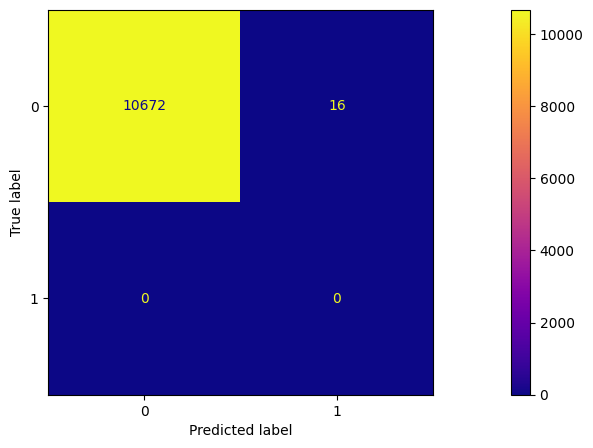

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axs = plt.subplots(1, 1, figsize=(20, 5))


confusion = confusion_matrix(test_dataset['relevance'].to_numpy(), test_dataset['prediction'].to_numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
disp.plot(ax=axs, cmap='plasma')

plt.show()

In [35]:
def readjust_threshold(probabilities, threshold=0.5):
    return (probabilities > threshold).astype(f'<U{len("irrelevant")}').replace({'True': 'relevant', 'False': 'irrelevant'})

In [40]:
readjust_threshold(test_dataset['score'], threshold=0.5).value_counts()

score
irrelevant    10672
relevant         16
Name: count, dtype: int64

  0%|          | 0/40 [00:00<?, ?it/s]

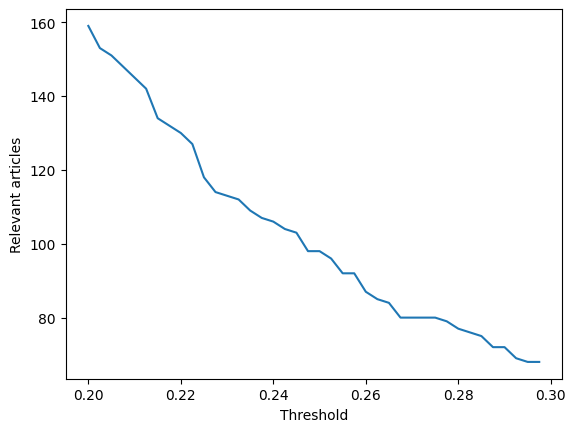

In [43]:
from numpy import arange
ranges = list(arange(0.2,0.3,0.0025))

relevants = []

for threshold in tqdm(ranges):
    new_predictions = readjust_threshold(test_dataset['score'], threshold=threshold)
    relevants.append(len(new_predictions[new_predictions == 'relevant']))

plt.plot(ranges, relevants)
plt.xlabel('Threshold')
plt.ylabel('Relevant articles')
plt.show()



In [38]:
# pd.options.display.max_colwidth = 200

display(test_dataset[test_dataset['prediction']=='relevant'][['url', 'score', 'prediction','text']])

,url,score,prediction,text
6406,https://digitalarchive.worldfishcenter.org/bit...,0.854538,relevant,MARINE ECOLOGY PROGRESS SERIES Vol. 588: 85–10...
6160,https://wsobirds.org/images/pdfs/BeyondBirdFee...,0.825297,relevant,BEYOND THE BIRD FEEDER: Creating a Bird-Friend...
6817,https://digitalarchive.worldfishcenter.org/bit...,0.789381,relevant,"S t a From October 2006 to May 2008, The World..."
3179,https://wwjournal.org/wp-content/uploads/sites...,0.721217,relevant,Western Wildlife 11:11–18 • 2024 Submitted: 18...
2151,https://cms.zsl.org/sites/default/files/2022-1...,0.704993,relevant,CAFF Assessment Series Report September 2015 A...
7698,https://zooreach.org/downloads/ZOO_CAMP_PHVA_r...,0.690064,relevant,THE STATUS AND DISTRIBUTION OF REPTILES IN THE...
7400,https://cms.zsl.org/sites/default/files/2022-1...,0.688614,relevant,W Stefanie Deinet I L D Christina Ieronymidou ...
6766,https://apps.worldagroforestry.org/downloads/P...,0.682692,relevant,Conservation Agriculture With Trees: Principle...
5539,http://www.wpcouncil.org/wp-content/uploads/20...,0.662959,relevant,2021 Quantitative estimates of post-release su...
6736,http://wiki.daz3d.com/lib/exe/fetch.php/public...,0.638514,relevant,Avian Models for 3D Applications by Ken Gillil...


In [39]:
test_dataset[test_dataset['prediction']=='relevant']['url'].to_numpy()

array(['https://digitalarchive.worldfishcenter.org/bitstream/handle/20.500.12348/692/4226.pdf?sequence=1&isAllowed=y',
       'https://wsobirds.org/images/pdfs/BeyondBirdFeederBookletFINAL.compressed.pdf',
       'https://digitalarchive.worldfishcenter.org/bitstream/handle/20.500.12348/1418/WF_2033.pdf?sequence=1&isAllowed=y',
       'https://wwjournal.org/wp-content/uploads/sites/9/2024/06/Roy_etal_WW_2024.pdf',
       'https://cms.zsl.org/sites/default/files/2022-12/ASTI_MigBirds_Index_2015_0.pdf',
       'https://zooreach.org/downloads/ZOO_CAMP_PHVA_reports/2014-Reptile-Report.pdf',
       'https://cms.zsl.org/sites/default/files/2022-12/wildlife-comeback-in-europe.pdf',
       'https://apps.worldagroforestry.org/downloads/Publications/PDFS/TM17693.pdf',
       'http://www.wpcouncil.org/wp-content/uploads/2020/11/08.C1-Hutchinson-et-al-2021.pdf',
       'http://wiki.daz3d.com/lib/exe/fetch.php/public/read_me/index/16122/16122_songbirdremixvultures2.pdf',
       'https://wos.org/docu